<a href="https://colab.research.google.com/github/nid-amn/SRGAN_BSD100/blob/main/SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display

from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm
from keras.applications import VGG19

In [ ]:
folder_path = '/content/drive/MyDrive/data/bsd100/bicubic_2x/train/HR'


file_list = os.listdir(folder_path)
image_count = len([file for file in file_list])
print(image_count)

80


In [ ]:
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)



In [ ]:
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [ ]:
import os
import cv2
n=80
lr_path ='/content/drive/MyDrive/data/bsd100/bicubic_2x/train/LR'
hr_path ='/content/drive/MyDrive/data/bsd100/bicubic_2x/train/HR'

# lr_path_val = '/content/drive/MyDrive/data/bsd100/bicubic_2x/val/LR'
# hr_path_val = '/content/drive/MyDrive/data/bsd100/bicubic_2x/val/HR'

lr_list = os.listdir(lr_path)
hr_list = os.listdir(hr_path)

# lr_list_val = os.listdir(lr_path_val)
# hr_list_val = os.listdir(hr_path_val)

target_lr = (32,32)
target_size=(128,128)

lr_images = []
hr_images = []

for img in lr_list:
  img_lr = cv2.imread(lr_path+'/' + img)
  img_hr = cv2.imread(hr_path+'/' + img)

  img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
  img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
  img_lr = cv2.resize(img_lr, target_lr)
  img_hr = cv2.resize(img_hr, target_size)
  lr_images.append(img_lr)
  hr_images.append(img_hr)

# lr_images_val = []
# hr_images_val = []

# for img in lr_list_val:
#   img_lr = cv2.imread(lr_path_val+'/' + img)
#   img_hr = cv2.imread(hr_path_val+'/' + img)

#   img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
#   img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
#   img_lr = cv2.resize(img_lr, target_lr)
#   img_hr = cv2.resize(img_hr, target_size)

#   lr_images_val.append(img_lr)
#   hr_images_val.append(img_hr)


# for image_number in range(60):
#   plt.figure(figsize=(12, 6))
#   plt.subplot(121)
#   plt.imshow(np.reshape(lr_images[image_number], (128, 128, 3)))
#   plt.subplot(122)
#   plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
#   plt.show()

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)
# lr_images_val = np.array(lr_images_val)
# hr_images_val = np.array(hr_images_val)

print("Low-resolution images shape:", lr_images.shape)
print("High-resolution images shape:", hr_images.shape)
# print("Low-resolution images shape:", lr_images_val.shape)
# print("High-resolution images shape:", hr_images_val.shape)


Low-resolution images shape: (80, 32, 32, 3)
High-resolution images shape: (80, 128, 128, 3)


71


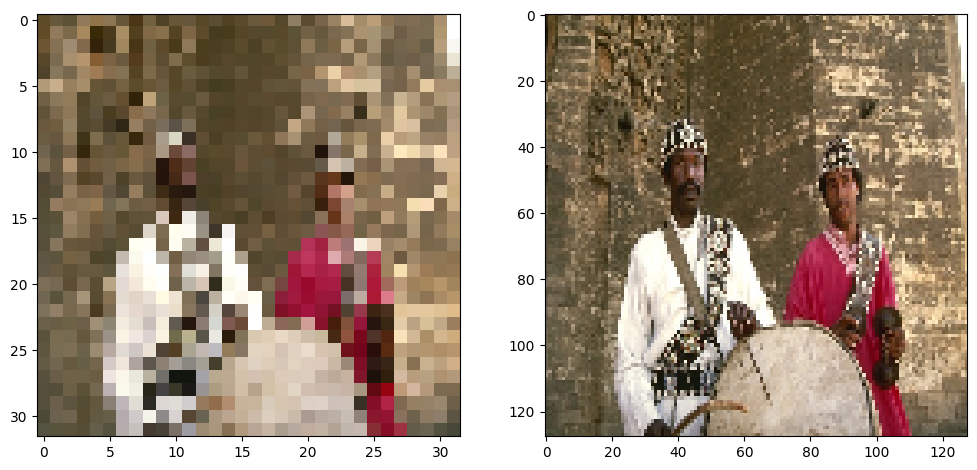

[[[ 93  74  38]
  [102  88  59]
  [ 93  82  54]
  ...
  [120 105  81]
  [170 144 111]
  [254 255 255]]

 [[ 96  75  39]
  [144 122  91]
  [123 105  73]
  ...
  [121 107  82]
  [175 151 112]
  [254 255 254]]

 [[109  85  52]
  [132 112  83]
  [158 139 114]
  ...
  [104  94  71]
  [182 157 124]
  [248 247 242]]

 ...

 [[ 84  78  60]
  [107  95  76]
  [ 93  84  63]
  ...
  [148 129 102]
  [153 136 109]
  [110  95  73]]

 [[ 76  73  55]
  [108  97  78]
  [111 101  79]
  ...
  [140 122  99]
  [141 127 107]
  [ 93  85  67]]

 [[ 84  82  65]
  [ 87  82  60]
  [ 89  81  58]
  ...
  [106  99  82]
  [ 82  80  62]
  [ 72  72  56]]]


In [ ]:
import random
image_number = random.randint(0, len(lr_images)-1)
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()
print(lr_images[image_number])

In [ ]:
lr_train = lr_images / 255.
hr_train = hr_images / 255.
# lr_test= lr_images_val / 255.
# hr_test = hr_images_val / 255.

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_train, hr_train, test_size=0.33, random_state=42)

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
hr_shape_test = (hr_test.shape[1], hr_test.shape[2], hr_test.shape[3])
lr_shape_test = (lr_test.shape[1], lr_test.shape[2], lr_test.shape[3])


lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)
lr_ip_test = Input(shape=lr_shape_test)
hr_ip_test = Input(shape=hr_shape_test)
print(lr_ip)
print(hr_ip)
print(lr_ip_test)
print(hr_ip_test)

<KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=None, name=keras_tensor>
<KerasTensor shape=(None, 128, 128, 3), dtype=float32, sparse=None, name=keras_tensor_1>
<KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=None, name=keras_tensor_2>
<KerasTensor shape=(None, 128, 128, 3), dtype=float32, sparse=None, name=keras_tensor_3>


In [ ]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │         15,616 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_re_lu (PReLU)           │ (None, 32, 32, 64)     │             64 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ p_re_lu[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_re_lu_1 (PReLU)         │ (None, 32, 32, 64)     │             64 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ p_re_lu_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ p_re_lu[0][0],         │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_re_lu_2 (PReLU)         │ (None, 32, 32, 64)     │             64 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ p_re_lu_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 32, 32, 64)     │              0 │ add[0][0],             │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 2,044,291 (7.80 MB)

 Trainable params: 2,040,067 (7.78 MB)

 Non-trainable params: 4,224 (16.50 KB)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,1

 Total params: 38,249,281 (145.91 MB)

 Trainable params: 38,245,569 (145.90 MB)

 Non-trainable params: 3,712 (14.50 KB)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,325,568 (8.87 MB)

 Trainable params: 2,325,568 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 128, 128, 3)    │      2,044,291 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 1)              │     38,249,281 │ functional[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 32, 32, 256)    │      2,325,568 │ functional[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 42,619,140 (162.58 MB)

 Trainable params: 2,040,067 (7.78 MB)

 Non-trainable params: 40,579,073 (154.80 MB)

In [ ]:
batch_size = 16
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
epochs = 10
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

    #Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []

    #Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

        #First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        #Average the discriminator loss, just for reporting purposes.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
        #Train the generator via GAN.
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #Save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    #Report the progress during training.
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 5 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("/content/drive/MyDrive/data/saved_models/gen_e_"+ str(e+1) +".keras")

gan_model.save('/content/drive/MyDrive/data/model/SRGAN_2.h5')

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 33%|███▎      | 1/3 [01:23<02:46, 83.29s/it]WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_iterator at 0x7a8cdd555e10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 2/3 [01:27<00:36, 36.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|██████████| 3/3 [01:32<00:00, 30.99s/it]


epoch: 1 g_loss: 66.6513671875 d_loss: [53.714554    0.36128473]


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 1/3 [00:04<00:09,  4.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 2/3 [00:09<00:04,  4.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


epoch: 2 g_loss: 29.7608642578125 d_loss: [31.277643   0.4373189]


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 1/3 [00:04<00:09,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 2/3 [00:09<00:04,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


100%|██████████| 3/3 [00:14<00:00,  4.97s/it]


epoch: 3 g_loss: 19.039199829101562 d_loss: [19.645563    0.52861935]


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 1/3 [00:04<00:09,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 2/3 [00:09<00:04,  4.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


100%|██████████| 3/3 [00:15<00:00,  5.07s/it]


epoch: 4 g_loss: 13.888231913248697 d_loss: [14.222405  0.634492]


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 1/3 [00:05<00:10,  5.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 2/3 [00:10<00:05,  5.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


epoch: 5 g_loss: 10.991779327392578 d_loss: [11.188347    0.70057964]


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 1/3 [00:04<00:09,  4.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|██████▋   | 2/3 [00:10<00:05,  5.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|██████████| 3/3 [00:15<00:00,  5.14s/it]


epoch: 6 g_loss: 9.090533574422201 d_loss: [9.225047   0.74733543]


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 1/3 [00:05<00:10,  5.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 67%|██████▋   | 2/3 [00:10<00:05,  5.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|██████████| 3/3 [00:15<00:00,  5.07s/it]


epoch: 7 g_loss: 7.776167551676433 d_loss: [7.8692207 0.7771036]


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 1/3 [00:05<00:11,  5.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 2/3 [00:10<00:05,  5.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|██████████| 3/3 [00:15<00:00,  5.09s/it]


epoch: 8 g_loss: 6.776462554931641 d_loss: [6.851771  0.8028957]


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 33%|███▎      | 1/3 [00:06<00:12,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 2/3 [00:10<00:05,  5.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|██████████| 3/3 [00:15<00:00,  5.27s/it]


epoch: 9 g_loss: 6.010801951090495 d_loss: [6.0675216  0.82263994]


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 33%|███▎      | 1/3 [00:05<00:11,  5.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 2/3 [00:10<00:05,  5.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|██████████| 3/3 [00:16<00:00,  5.40s/it]


epoch: 10 g_loss: 5.394890467325847 d_loss: [5.44229    0.84007627]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


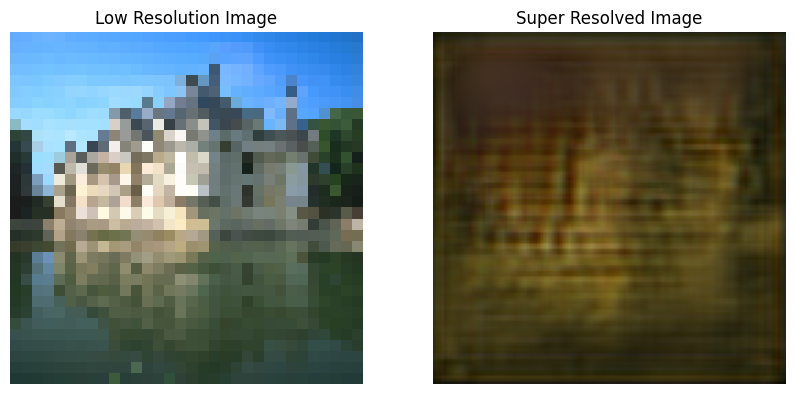

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/data/saved_models/gen_e_10.keras', compile=False)

# Read and preprocess images
sreeni_lr = cv2.imread("/content/drive/MyDrive/data/bsd100/bicubic_2x/val/LR/102061.png")
sreeni_hr = cv2.imread("/content/drive/MyDrive/data/bsd100/bicubic_2x/val/HR/102061.png")

sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

# Resize images
target_lr = (32, 32)  # Example target size for low-res, adjust as needed
target_size = (64, 64)  # Example target size for high-res, adjust as needed
sreeni_lr = cv2.resize(sreeni_lr, target_lr)
sreeni_hr = cv2.resize(sreeni_hr, target_size)

# Normalize the images
sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

# Add batch dimension
sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

def predict_srgan(low_res_image):
    sr_image = model.predict(low_res_image)
    sr_image = np.squeeze(sr_image)
    return sr_image

def display_images(low_res, sr_image):
    # Display the images side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Low Resolution Image")
    plt.imshow(low_res)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Super Resolved Image")
    plt.imshow(sr_image)
    plt.axis('off')

    plt.show()

# Predict and display the result
low_res_image = np.squeeze(sreeni_lr)
sr_image = predict_srgan(sreeni_lr)
display_images(low_res_image, sr_image)

# Save the super-resolved image
sr_image = (sr_image * 255).astype(np.uint8)
cv2.imwrite('/content/drive/MyDrive/data/bsd100/bicubic_2x/output/102061_1.png', cv2.cvtColor(sr_image, cv2.COLOR_RGB2BGR))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


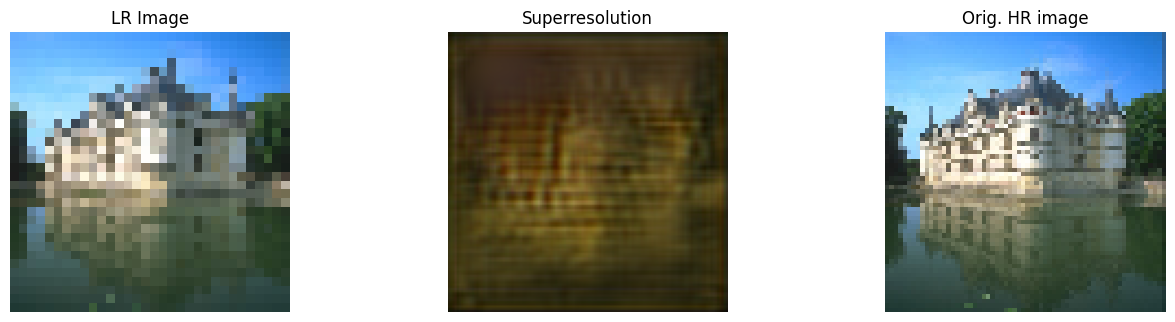

In [ ]:

generated_sreeni_hr = predict_srgan(sreeni_lr)

plt.figure(figsize=(16, 8))

plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0])
plt.axis('off')

plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr)
plt.axis('off')

plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0])
plt.axis('off')

plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100  # Images are identical
    PIXEL_MAX = 255.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr

target_size = (128,128)
hr_image_path = '/content/drive/MyDrive/data/bsd100/bicubic_2x/val/HR/102061.png'
sr_image_path = '/content/drive/MyDrive/data/bsd100/bicubic_2x/output/102061_1.png'

hr_image = cv2.imread(hr_image_path)
sr_image = cv2.imread(sr_image_path)

hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)
sr_image = cv2.cvtColor(sr_image, cv2.COLOR_BGR2RGB)
hr_image = cv2.resize(hr_image, target_size)
sr_image = cv2.resize(sr_image, target_size)

psnr_value = calculate_psnr(hr_image, sr_image)
print(f"PSNR value: {psnr_value}")

image1 = io.imread(hr_image_path, as_gray=True)
image2 = io.imread(sr_image_path, as_gray=True)

image1_resized = resize(image1, target_size, anti_aliasing=True)
image2_resized = resize(image2, target_size, anti_aliasing=True)

data_range = image1_resized.max() - image1_resized.min()

ssim_index, _ = ssim(image1_resized, image2_resized, data_range=data_range, full=True)

print("SSIM Index:", ssim_index)


PSNR value: 27.986309924236235
SSIM Index: 0.3496909279017621
